In [ ]:
from nbdev import *

In [ ]:
%nbdev_hide
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%nbdev_default_export dr

Cells will be exported to pacmel_mining_use_case.dr,
unless a different module is specified after an export flag: `%nbdev_export special.module`


## Notebook parameters

Put here everything that could be needed if this notebook was called from outside, using papermill. Parameters that are part of a sweep do not need to be defined here, even if they are called through papermill

In [ ]:
dr_artifact_name = 'JNK:v3' # * Set to None for using the default one (DCAE)
dcae_run_path = 'pacmel/timecluster-extension/24kd7cn2' # *

# Dimensionality reduction

> This notebook gets the latent features from a multivariate time series 
given by an autoencoder and uses them as input for a dimensionality reduction algorithm

In [ ]:
%nbdev_export
import umap
import pandas as pd
import numpy as np
from fastcore.all import *
from timecluster_extension.load import *
from timecluster_extension.utils import *

In [ ]:
%nbdev_hide
import matplotlib.pyplot as plt
import wandb
from yaml import load, FullLoader
from tensorflow.keras.models import load_model

This model needs to restore the model fitted in the notebook `01_DCAE`, as well as the data and configuration

Taking the best run from a sweep. 

In [ ]:
run_dr = wandb.init(project="timecluster-extension", 
                    allow_val_change=True, 
                    job_type='dimensionality_reduction')
config_dr = wandb.config # Object for storing hyperparameters

wandb: Currently logged in as: vrodriguezf (use `wandb login --relogin` to force relogin)


Restore a DCAE model and its associated configuration

In [ ]:
dcae_model = load_model(wandb.restore('model-best.h5', replace=True, run_path=dcae_run_path).name)
with open(wandb.restore('config.yaml', replace=True, run_path=dcae_run_path).name) as file:
    dcae_config = load(file, FullLoader)

In [ ]:
config_dr.update({
    'dcae_run_path' : dcae_run_path
    }, 
    allow_val_change=True
)
print(config_dr)

{'dcae_run_path': 'vrodriguezf/timecluster-extension/pvs3zkqd'}


Restore the dataset artifact used for creating the DCAE. Even if we do not compute the dimensionality reduction over this dataset,
we need to know the metadata of the dataset of the DCAE, to check that it matches with the dataset that we want to reduce.

In [ ]:
dcae_artifact_type = dcae_config.get('ds_artifact_type').get('value')
dcae_artifact_name = dcae_config.get('ds_artifact_name').get('value')
dcae_artifact_digest = dcae_config.get('ds_artifact_digest').get('value')
dcae_artifact_type, dcae_artifact_name, dcae_artifact_digest

('dataset', 'JNK:v7', '3f846b69e5c7e6df6683460323dcba0b')

In [ ]:
dcae_artifact = run_dr.use_artifact(dcae_artifact_name)
dcae_artifact.metadata

{'TS': {'ed': '2019-06-30 00:00:00',
  'sd': '2019-06-01 00:00:00',
  'freq': '<5 * Seconds>',
  'hash': '-2568758837685750672',
  'vars': ['RCD_AverageThree-phaseCurrent',
   'LCD_AverageThree-phaseCurrent',
   'LP_AverageThree-phaseCurrent',
   'LHD_LeftHaulageDrive(tractor)Temperature(gearbox)',
   'RHD_RightHaulageDrive(tractor)Temperature(gearbox)',
   'LA_LeftArmTemperature',
   'RA_RightArmTemperature',
   'SM_DailyRouteOfTheShearer',
   'SM_TotalRoute',
   'LHD_EngineCurrent',
   'RHD_EngineCurrent',
   'RCD_BearingTemperature',
   'SM_ShearerSpeed',
   'SM_ShearerLocation',
   'SM_ShearerMoveInLeft',
   'SM_ShearerMoveInRight'],
  'n_vars': 16,
  'created': 'from-df',
  'n_samples': 501121,
  'normalization': {'stds': {'SM_TotalRoute': 25.04366490593873,
    'SM_ShearerSpeed': 2.9198292690278103,
    'LHD_EngineCurrent': 21.93831294062176,
    'RHD_EngineCurrent': 21.21578937550054,
    'SM_ShearerLocation': 78.26614419252932,
    'SM_ShearerMoveInLeft': 0.2554890106589118,
  

Now we specify the dataset artifact that we want to use for the reduction. If no artifact is defined, the artifact to reduce will be the one used for training the DCAE.

In [ ]:
if dr_artifact_name is not None:
    dr_artifact = run_dr.use_artifact(dr_artifact_name, type='dataset')
else:
    dr_artifact = dcae_artifact

Now we need to check whether the artifact that is going to be used fort the dimensionality reduction matches the artifact used to train the DCAE. Matching means having the same number of variables, the same window size and stride, and the same frequency.

In [ ]:
%nbdev_export
def check_compatibility(dr_ar:TSArtifact, dcae_ar:TSArtifact):
    "TODO: Function to check that the artifact used by the DCAE and the artifact that is \
    going to be passed through the DR are compatible"
    ret = dr_ar.metadata['TS']['vars'] == dcae_ar.metadata['TS']['vars']
    # Check that the dr artifact is not normalized
    return ret

In [ ]:
df = dr_artifact.to_df()
df

wandb: Downloading large artifact JNK:v7, 65.00MB. 1 files... Done. 0.5s


,RCD_AverageThree-phaseCurrent,LCD_AverageThree-phaseCurrent,LP_AverageThree-phaseCurrent,LHD_LeftHaulageDrive(tractor)Temperature(gearbox),RHD_RightHaulageDrive(tractor)Temperature(gearbox),LA_LeftArmTemperature,RA_RightArmTemperature,SM_DailyRouteOfTheShearer,SM_TotalRoute,LHD_EngineCurrent,RHD_EngineCurrent,RCD_BearingTemperature,SM_ShearerSpeed,SM_ShearerLocation,SM_ShearerMoveInLeft,SM_ShearerMoveInRight
TIMESTAMP,,,,,,,,,,,,,,,,
2019-06-01 00:00:00,-0.971566,-0.958893,-0.714756,-2.506141,-0.22915,-3.602263,-3.374381,-1.065309,-6.196249,-0.591877,-0.590393,-3.528427,-0.391898,0.807398,-0.284494,-0.346266
2019-06-01 00:00:05,-0.971566,-0.958893,-0.714756,-2.506141,-0.22915,-3.602263,-3.374381,-1.065309,-6.196249,-0.591877,-0.590393,-3.528427,-0.391898,0.807398,-0.284494,-0.346266
2019-06-01 00:00:10,-0.971566,-0.958893,-0.714756,-2.506141,-0.22915,-3.602263,-3.374381,-1.065309,-6.196249,-0.591877,-0.590393,-3.528427,-0.391898,0.807398,-0.284494,-0.346266
2019-06-01 00:00:15,-0.971566,-0.958893,-0.714756,-2.506141,-0.22915,-3.602263,-3.374381,-1.065309,-6.196249,-0.591877,-0.590393,-3.528427,-0.391898,0.807398,-0.284494,-0.346266
2019-06-01 00:00:20,-0.971566,-0.958893,-0.714756,-2.506141,-0.22915,-3.602263,-3.374381,-1.065309,-6.196249,-0.591877,-0.590393,-3.528427,-0.391898,0.807398,-0.284494,-0.346266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-29 23:59:40,-0.639781,-0.669682,-0.714756,0.787827,-0.22915,0.415994,0.293725,-0.333925,1.474354,-0.591877,-0.590393,0.253327,-0.391898,0.781844,-0.284494,-0.346266
2019-06-29 23:59:45,-0.639781,-0.669682,-0.714756,0.787827,-0.22915,0.415994,0.293725,-0.333925,1.474354,-0.591877,-0.590393,0.253327,-0.391898,0.781844,-0.284494,-0.346266
2019-06-29 23:59:50,-0.639781,-0.669682,-0.714756,0.787827,-0.22915,0.415994,0.293725,-0.333925,1.474354,-0.591877,-0.590393,0.253327,-0.391898,0.781844,-0.284494,-0.346266


In [ ]:
dcae_input = df_slicer(df=df[:1000], # TODO: This is just for testing, the subset must be something implicit in the artifact
                       w=dcae_config.get('w').get('value'),
                       s=dcae_config.get('stride').get('value'))
dcae_input.shape

(953, 48, 16)

### Getting the latent variables from the trained model

Once the DCAE model is trained, we are interested in the information contained in the **Dense** layer (also called *bottleneck*)for each slice of data. To do that, we have to call the `predict` function on an intermediate model that gets the output of the intermediate layer.

In [ ]:
%nbdev_export dcae
from tensorflow.keras.models import Model
def get_latent_features(dcae, input_data, bottleneck_ln='latent_features'):
    "Get the activations of the bottleneck layer within the fitted autoencoder `dcae` (a Keras model) \
    for the input data `input_data` (a tensor). The name of the bottleneck layer is given in `bottleneck_ln"
    layer_latent_output = dcae.get_layer(bottleneck_ln).output
    intermediate_model = Model(inputs=dcae.input, outputs=layer_latent_output)
    intermediate_prediction = intermediate_model.predict(input_data)
    return intermediate_prediction

In [ ]:
intermediate_prediction = get_latent_features(dcae_model, dcae_input, 'latent_features')
intermediate_prediction.shape

(953, 48)

## Dimensionality reduction using UMAP

We use DR techniques to provide an alternative view for users to visually analyze and explore the time-series data. The algorithm UMAP shows its high competitiveness compared to t-SNE. t-SNE suffers from some limitations such as loss of large-scale information (the inter-cluster relationships). UMAP has a faster runtime and provides better scaling which helps to gain a meaningful organization of clusters, outliers and the preservation of continuums compared to t-SNE

For this part of the implementation, the package [umap-learn](https://github.com/lmcinnes/umap) is used. The input of the algoritm is the $n \times \delta$ that contains, for each slice of the time series, the corresponding $\delta$ latent features given by the DCAE.

The hyperparameters of UMAP are given values by default here. If the value has been already set previously, that means this notebook is being called from a wandb sweep, and we must use the value that the sweep is bringing.

In [ ]:
config_dr.n_neighbors = ifnone(config_dr.get('n_neighbors'), 15)
config_dr.min_dist = ifnone(config_dr.get('min_dist'), 0.1)
config_dr.metric = ifnone(config_dr.get('metric'), 'euclidean')

NameError: name 'config_dr' is not defined

In [ ]:
umap_params = {
    'n_neighbors' : config_dr.n_neighbors,
    'min_dist' : config_dr.min_dist,
    'metric' : config_dr.metric,
    'verbose': True
}

In [ ]:
# config_dr.update(umap_params, allow_val_change=True)

Finall, we gather all this functionality into a function for future use

In [ ]:
%nbdev_export
import warnings
from numba.core.errors import NumbaPerformanceWarning
@delegates(umap.umap_.UMAP)
def fget_UMAP_embeddings(input_data, **kwargs):
    "Compute the embeddings of `input_data` using UMAP, with a configuration contained in `**kwargs`. \
    Returns also information of the reducer."
    warnings.filterwarnings("ignore", category=NumbaPerformanceWarning) # silence NumbaPerformanceWarning
    reducer = umap.UMAP(**kwargs)
    reducer.fit(input_data)
    embeddings = reducer.transform(input_data)
    return (embeddings, reducer)

In [ ]:
%%time
embeddings, reducer = fget_UMAP_embeddings(intermediate_prediction, **umap_params)
embeddings.shape

UMAP(min_dist=0.2, n_neighbors=5, verbose=True)
Construct fuzzy simplicial set
Tue Oct  6 17:56:39 2020 Finding Nearest Neighbors
Tue Oct  6 17:56:42 2020 Finished Nearest Neighbor Search
Tue Oct  6 17:56:45 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Oct  6 17:56:48 2020 Finished embedding
CPU times: user 47 s, sys: 24.1 s, total: 1min 11s
Wall time: 9.26 s


(953, 2)

In [ ]:
test_eq(embeddings.shape, (intermediate_prediction.shape[0], reducer.n_components))

In [ ]:
# Test if the reducer contains the items of the configuration object
test_eq(all(item in reducer.get_params().items() for item in dict(umap_params).items()), True)

Save the embeddings as an artifact

In [ ]:
from timecluster_extension.utils import ReferenceArtifact

In [ ]:
embeddings_ar = ReferenceArtifact(obj=embeddings, name='embeddings')
embeddings_ar.metadata, embeddings_ar.manifest.entries.values()

({'ref': {'hash': '-1465390000900815529', 'type': "<class 'numpy.ndarray'>"}},
 dict_values([<ManifestEntry ref: file:///home/user/data/PACMEL-2019/wandb_artifacts/-1465390000900815529/-1465390000900815529>]))

In [ ]:
run_dr.log_artifact(embeddings_ar)

In [ ]:
embeddings_ar.digest

'3f95f1fb78721dfe1ad09659b3280da9'

In [ ]:
config_dr.update(
    {
          'emb_artifact_type': embeddings_ar.type,
          'emb_artifact_name': embeddings_ar.name,
          'emb_artifact_digest': embeddings_ar.digest
    }, 
    allow_val_change=True)

## 2D Visualization 

While the connected scatter plot is a simple visualization technique, it has very specific functions in our approach. Every sliding window is represented as a dot in the plot after the projection process (Fig. 4C, D of the paper). Before labeling, all points have the same color and transparency, and when they are concentrated in one area, the densities are accumulated. Lines are used to connect consecutive points preserving the temporal ordering of the data and allowing the user to see temporal connections (Fig. 4B of the paper). Thus, the point is linked to the previous point (inner) and to the posterior point (outer) as an indication of the flow of time.

In [ ]:
%nbdev_export
def plot_embeddings(embeddings):
    "Plot 2D embeddings thorugh a connected scatter plot"
    df_embeddings = pd.DataFrame(embeddings, columns = ['x1', 'x2'])
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.scatter(df_embeddings['x1'], df_embeddings['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
    ax.plot(df_embeddings['x1'], df_embeddings['x2'], alpha=0.5, picker=1)
    return ax

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Setting the line's pick radius via set_picker is deprecated since 3.3 and will be removed two minor releases later; use set_pickradius instead.
  


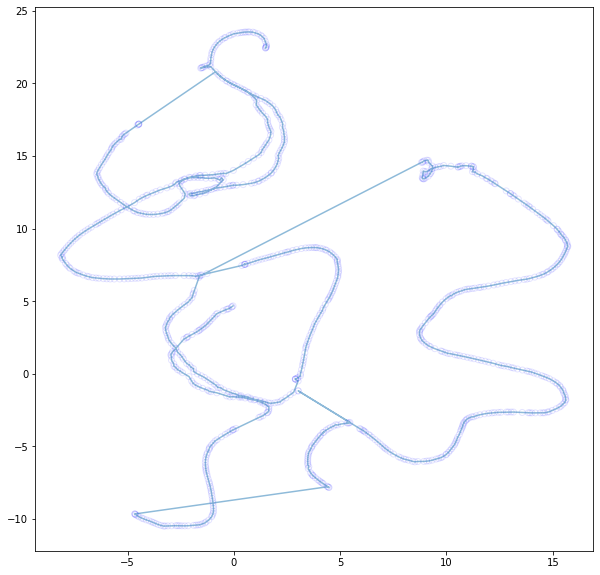

In [ ]:
embeddings_plot = plot_embeddings(embeddings)

Log this plot as part of the current wandb run

In [ ]:
%nbdev_hide
run_dr.log({'embeddings_plot': embeddings_plot})

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mplexporter/exporter.py:267: MatplotlibDeprecationWarning:


The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.



In [ ]:
run_dr.finish()

# Explainability with SHAP (future work)

In [ ]:
# %matplotlib inline

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111)

# ax.scatter(df_embeddings['x1'], df_embeddings['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
# ax.plot(df_embeddings['x1'], df_embeddings['x2'], alpha=0.5, picker=1)
# ax.set_title('Select the point you want to visualize as a time window in the original space')

Make the plot interactive to allow selection of subsets of the plot

In [ ]:
# selected_indices = None
# selected_points = None

# def onpick(event):
#     global selected_points
#     thisline = event.artist
#     xdata = thisline.get_xdata()
#     ydata = thisline.get_ydata()
#     global selected_indices
#     selected_indices = event.ind
#     selected_points = tuple(zip(xdata[selected_indices], ydata[selected_indices]))
#     print('onpick points (first):', selected_points[0])

# fig.canvas.mpl_connect('pick_event', onpick)

# plt.show()
# fig.tight_layout()
# fig.savefig(f'../img/w={w}.png')

## Hyperparameter tuning for the dimensionality reduction

There are a number of parameters that can be set for the UMAP algorithm. The major 
ones are `n_neighbors` and `min_dist`. Thus, we will carry out a hyperparameter 
sweep in Weights and Biases for these two parameters. Note that there is no objective
way of deciding that some embeddings are better than others. Thus, we must rely on our
intuition by visualizing the 2D plots of each of the runs in the sweep.

The first thing we need is gather all the pipeline of the previous section into a function


## Linking back points of the 2D projection to the original time series

The variable `selected_points` and `ind` contain an array of the points and indices selected in the previous 2D projection. We will take the first of them (there can be many selected points with just one click), and use its index to get the corresponding time window of the original space.

In [ ]:
# selected_window = input_data[df_embeddings.sample(n=1).index][0] if selected_indices is None else input_data[selected_indices[0]]
# selected_window

### Visualizing all the variables in the time window (default)

In [ ]:
# %matplotlib inline
# g = sns.FacetGrid(df_output_tidy, col="variable", col_wrap=3, aspect=2)
# g = g.map(plt.plot, "timestamp", "value")

### Contribution: Visualize only the most relevant variables

In high dimensional time series, not only is interesting to see the window associated to a point in the 2D space, but also it is extremely important to spot which variables are mainly causing that the window is positioned in that point of the 2D space.

Since UMAP does not provide capabilities to understand feature importance, there are [different ways](https://stats.stackexchange.com/questions/438025/understand-important-features-in-umap) to tackle this problem:

1. Use another dimensionality reduction technique that provides importance, such as [sparse PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html)

2. Create a surrogate model on top of the inputs/output of UMAP and explain it using XAI techniques. We will try here this option.

The idea is to have a surrogate model that takes the multivariate time series as input and produces the associated points in the 2D space as ouput. Since we already have a Deep Convolutional Autoencoder (DCAE) that takes a multivariate time series as input, and it contains the latent features that represent that input, we can use it for the surrogate. We will use the intermediate model that goes from the input to the layer containing the latent space, and then add a `Dense` layer with 2 units and linear activation.

In [ ]:
%nbdev_export
# def train_surrogate_model(dcae, embeddings, lat_ln='latent_features'):
#     "Train a surrogate model that learns the `embeddings` from the latent features contained in the layer \
#     `lat_ln` of a previously trained Deep Convolutional AutoEncoder `dcae`"
#     x = dcae.get_layer(lat_ln).output
#     x = Dense(units=embeddings.shape[1], activation='linear')(x)
#     surrogate_model = Model(dcae.input, x)
#     l_nms = [layer.name for layer in surrogate_model.layers]
#     layer_idx = l_nms.index(lat_ln)
#     # The layers that are already trained from the autoencoder must be `frozen`
#     for layer in surrogate_model.layers[:layer_idx]:
#         layer.trainable = False
#     return surrogate_model

In [ ]:
# sm = train_surrogate_model(m, embeddings, lat_ln='latent_features')

In [ ]:
# test.equals(sm.input.shape, m.input.shape)
# test.equals(sm.output.shape[1], embeddings.shape[1])
# l_nms = [layer.name for layer in sm.layers]
# layer_idx = l_nms.index('latent_features')
# test.all_equal([layer.trainable for layer in sm.layers], \
#                np.repeat([False, True], [layer_idx + 1, len(sm.layers) -1 -layer_idx]))

Configure the training hyperparameters

In [ ]:
# loss = 'mean_squared_error'
# opt = 'adam'
# bs = 100
# epochs = 10
# val = .2

In [ ]:
# sm.output_shape

In [ ]:
# input_data.shape

In [ ]:
# embeddings.shape

In [ ]:
# sm.fit(x=input_data, y=embeddings, batch_size=bs, validation_split=val, epochs=epochs, callbacks=[WandbCallback()])

In [ ]:
# import innvestigate

In [ ]:
# analyzer = innvestigate.create_analyzer("gradient", intermediate_model)

In [ ]:
# asd= innvestigate.create_analyzer("gradient", m)

In [ ]:
# from keras.datasets import mnist

In [ ]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
# x_train.shape

In [ ]:
# input_data[np.random.choice(input_data.shape[0], 100, replace=False)].shape

In [ ]:
# import shap

In [ ]:
# background = input_data[np.random.choice(input_data.shape[0], 100, replace=False)]
# e = shap.DeepExplainer(intermediate_model, background)

In [ ]:
# shap_values = e.shap_values(input_data[0:4])

In [ ]:
# shap_values[0][0]